# Photonics

In [1]:
import jax
import jax.numpy as jnp

from circulus.compiler import compile_netlist
from circulus.solvers.strategies import KLUSolver
from circulus.utils import update_group_params
import matplotlib.pyplot as plt
import time
from circulus.components import Resistor
from circulus.photonic_components import Grating, OpticalWaveguide, Splitter, OpticalSource

--- DEMO: Photonic Splitter & Grating Link (Wavelength Sweep) ---
Sweeping Wavelength...
Solving for single wavelength (and jit compiling)
Compilation and single point simulation Time: 2.227s
Sweeping DC Operating Point...
Vmap simulation Time: 2.501s


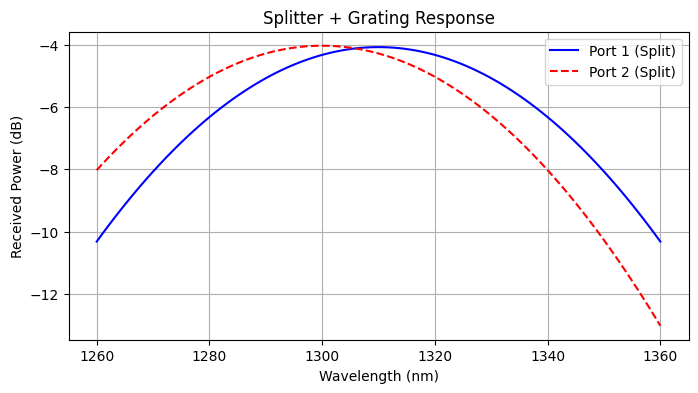

In [3]:
print("--- DEMO: Photonic Splitter & Grating Link (Wavelength Sweep) ---")

models_map = {
    'grating': Grating,
    'waveguide': OpticalWaveguide,
    'splitter': Splitter,
    'source': OpticalSource,
    'resistor': Resistor,
    'ground': lambda: 0
}

net_dict = {
    "instances": {
        "GND": {"component":"ground"},
        "Laser": {"component":"source", "settings":{"power": 1.0, "phase": 0.0}},
        "WG_In": {"component":"waveguide", "settings":{"length_um": 100.0}},
        "Splitter": {"component":"splitter", "settings":{"split_ratio": 0.5}},
        "WG_Arm1": {"component":"waveguide", "settings":{"length_um": 500.0}},
        "GC1":   {"component":"grating", "settings":{"peak_loss_dB": 1.0, "bandwidth_1dB": 40.0}},
        "Load1":  {"component":"resistor", "settings":{"R": 1.0}},
        "WG_Arm2": {"component":"waveguide", "settings":{"length_um": 50.0}},
        "GC2":   {"component":"grating", "settings":{"peak_loss_dB": 1.0, "bandwidth_1dB": 40.0, "center_wavelength_nm":1300}},
        "Load2":  {"component":"resistor", "settings":{"R": 1.0}},
    },
    "connections": {
        "GND,p1": ("Laser,p2", "Load1,p2", "Load2,p2"),
        "Laser,p1": "WG_In,p1",
        "WG_In,p2": "Splitter,p1",
        "Splitter,p2": "WG_Arm1,p1",
        "WG_Arm1,p2": "GC1,grating",
        "GC1,waveguide": "Load1,p1",
        "Splitter,p3": "WG_Arm2,p1",
        "WG_Arm2,p2": "GC2,grating",
        "GC2,waveguide": "Load2,p1",
    },
}

groups, sys_size, port_map = compile_netlist(net_dict, models_map)

wavelengths = jnp.linspace(1260, 1360, 100)

solver_strat = KLUSolver.from_circuit(groups, sys_size, is_complex=True)

print("Sweeping Wavelength...")
@jax.jit
def solve_for_loss(val):
    g = update_group_params(groups, 'grating', 'wavelength_nm', val)
    g = update_group_params(g, 'waveguide', 'wavelength_nm', val)
    y_flat = solver_strat.solve_dc(g, y_guess=jnp.ones(sys_size*2))
    return y_flat

start = time.time()
print("Solving for single wavelength (and jit compiling)")
solve_for_loss(1310)
total = time.time() - start
print(f"Compilation and single point simulation Time: {total:.3f}s")

print("Sweeping DC Operating Point...")
start = time.time()
solutions = jax.vmap(solve_for_loss)(wavelengths)
total = time.time() - start
print(f"Vmap simulation Time: {total:.3f}s")

v_out1 = solutions[:, port_map["Load1,p1"]] + 1j * solutions[:, port_map["Load1,p1"]+sys_size]
v_out2 = solutions[:, port_map["Load2,p1" ]] + 1j * solutions[:, port_map["Load2,p1"]+sys_size]

p_out1_db = 10.0 * jnp.log10(jnp.abs(v_out1)**2 + 1e-12)
p_out2_db = 10.0 * jnp.log10(jnp.abs(v_out2)**2 + 1e-12)

plt.figure(figsize=(8, 4))
plt.plot(wavelengths, p_out1_db, 'b-', label='Port 1 (Split)')
plt.plot(wavelengths, p_out2_db, 'r--', label='Port 2 (Split)')

plt.title("Splitter + Grating Response")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Received Power (dB)")
plt.legend()
plt.grid(True)
plt.show()